In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
# import warnings
# warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score
from impala.dbapi import connect
from impala.util import as_pandas
import pymysql

In [506]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [507]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

In [508]:
# 获取近期所有计划('2021年5月7号开始')
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2021-05-07'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-05-07'
                                and create_time <= '2021-05-08'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [509]:
# 获取image_id,label_ids
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2020-12-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [510]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= '2020-12-01' 
            AND b.tdate >= '2020-12-01' 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [511]:
# 获取近期账号维度窗口期统计数据
def getAdData(conn, begin, end, n):
    originSql = '''
              SELECT
                a.ad_account_id AS 'ad_account_id',
                ifnull( a.ad_amount, 0 ) AS 'ad_amount',
                ifnull( a.ad_create_role_num, 0 ) AS 'ad_create_role_num',
                ifnull( a.ad_new_role_money, 0 ) AS 'ad_new_role_money',
                ifnull( a.ad_pay_role_user_num, 0 ) AS 'ad_pay_role_user_num',
                ifnull( a.ad_source_num, 0 ) AS 'ad_source_num',
                IFNULL( b.ad_valid_source_num, 0 ) AS 'ad_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.ad_pay_role_user_num, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                    END 
                    ) AS 'ad_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                        END 
                        ) AS 'ad_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.ad_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'ad_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.ad_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.ad_valid_source_num, 0 ) / ifnull( a.ad_source_num, 0 ) 
                                END 
                                ) AS 'ad_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.ad_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.ad_new_role_money, 0 ) / ifnull( a.ad_amount, 0 ) 
                                    END 
                                    ) AS 'ad_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.ad_account_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'ad_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'ad_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'ad_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'ad_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'ad_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.ad_account_id,
                                            b.doc_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id 
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.ad_account_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.ad_account_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.ad_account_id,
                                        count( DISTINCT b.plan_id ) AS 'ad_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100  
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                    b.ad_account_id 
                ) b ON A.ad_account_id = B.ad_account_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [512]:
# 获取素材报表数据
def getImData(conn, begin, end, n):
    originSql = '''
            SELECT
                a.image_id AS 'image_id',
                ifnull( a.im_amount, 0 ) AS 'im_amount',
                ifnull( a.im_create_role_num, 0 ) AS 'im_create_role_num',
                ifnull( a.im_new_role_money, 0 ) AS 'im_new_role_money',
                ifnull( a.im_pay_role_user_num, 0 ) AS 'im_pay_role_user_num',
                ifnull( a.im_source_num, 0 ) AS 'im_source_num',
                IFNULL( b.im_valid_source_num, 0 ) AS 'im_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.im_pay_role_user_num, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                    END 
                    ) AS 'im_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                        END 
                        ) AS 'im_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.im_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'im_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.im_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.im_valid_source_num, 0 ) / ifnull( a.im_source_num, 0 ) 
                                END 
                                ) AS 'im_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.im_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.im_new_role_money, 0 ) / ifnull( a.im_amount, 0 ) 
                                    END 
                                    ) AS 'image_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.image_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'im_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'im_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'im_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'im_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'im_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.image_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id                                        
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.image_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.image_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.image_id,
                                        count( DISTINCT b.plan_id ) AS 'im_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100 
                                        AND b.image_id IS NOT NULL 
                                        AND b.image_id <> '' 
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1112 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                        b.image_id 
                                    ) b ON A.image_id = B.image_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [513]:
def etl_data(start, end, n):
    '''
    获取账号、素材、账号+素材维度的数据
    :return:
    '''
    # 链接数据库，并创建游标
    conn1 = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                            passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_data')
#     columns = ['ad_account_id', 'ad_amount', 'ad_create_role_num', 'ad_new_role_money',
#                'ad_pay_role_user_num', 'ad_source_num', 'ad_valid_source_num',
#                'ad_pay_rate', 'ad_create_role_cost', 'ad_create_role_pay_cost',
#                'ad_valid_source_rate', 'ad_create_role_roi', 'model_run_datetime']
    result_im = pd.DataFrame()
    result_ad = pd.DataFrame()
#     result_ad_im = pd.DataFrame()
    date_list = pd.date_range(start=start, end=end)
    for date in date_list:
        end = date
        begin = date - pd.Timedelta(days=n - 1)
        end = str(end).split(' ')[0]
        begin = str(begin).split(' ')[0]
        # 获取素材窗口期数据
        ImData = getImData(conn1, begin, end, n=n)
        ImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        # 获取账号窗口期数据
        AdData = getAdData(conn1, begin, end, n=n)
        AdData['model_run_datetime'] = date + pd.Timedelta(days=1)
#         # 获取账号+素材窗口期数据
#         AdImData = getAdImData(conn1, begin, end, n=n)
#         AdImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        result_im = result_im.append(ImData)
        result_ad = result_ad.append(AdData)
#         result_ad_im = result_ad_im.append(AdImData)

    conn1.close()
    return result_im, result_ad

In [404]:
# train_im_data_1['create_date'] = pd.to_datetime(train_im_data_1['create_date'])
# train_im_data_3['create_date'] = pd.to_datetime(train_im_data_3['create_date'])
# train_im_data_5['create_date'] = pd.to_datetime(train_im_data_5['create_date'])
# train_im_data_7['create_date'] = pd.to_datetime(train_im_data_7['create_date'])

In [405]:
# train_im_data_1 = train_im_data_1[train_im_data_1['create_date']<='2021-04-22']
# train_im_data_3 = train_im_data_3[train_im_data_3['create_date']<='2021-04-22']
# train_im_data_5 = train_im_data_5[train_im_data_5['create_date']<='2021-04-22']
# train_im_data_7 = train_im_data_7[train_im_data_7['create_date']<='2021-04-22']

In [406]:
# train_im_data_1.to_csv('./hist_data/im_data/train_data_1.csv',index=0)
# train_im_data_3.to_csv('./hist_data/im_data/train_data_3.csv',index=0)
# train_im_data_5.to_csv('./hist_data/im_data/train_data_5.csv',index=0)
# train_im_data_7.to_csv('./hist_data/im_data/train_data_7.csv',index=0)

In [407]:
# train_ad_data_1['create_date'] = pd.to_datetime(train_ad_data_1['create_date'])
# train_ad_data_3['create_date'] = pd.to_datetime(train_ad_data_3['create_date'])
# train_ad_data_5['create_date'] = pd.to_datetime(train_ad_data_5['create_date'])
# train_ad_data_7['create_date'] = pd.to_datetime(train_ad_data_7['create_date'])

In [408]:
# train_ad_data_1 = train_ad_data_1[train_ad_data_1['create_date']<='2021-04-22']
# train_ad_data_3 = train_ad_data_3[train_ad_data_3['create_date']<='2021-04-22']
# train_ad_data_5 = train_ad_data_5[train_ad_data_5['create_date']<='2021-04-22']
# train_ad_data_7 = train_ad_data_7[train_ad_data_7['create_date']<='2021-04-22']

In [409]:
# train_ad_data_1.to_csv('./hist_data/ad_data/train_data_1.csv',index=0)
# train_ad_data_3.to_csv('./hist_data/ad_data/train_data_3.csv',index=0)
# train_ad_data_5.to_csv('./hist_data/ad_data/train_data_5.csv',index=0)
# train_ad_data_7.to_csv('./hist_data/ad_data/train_data_7.csv',index=0)

In [514]:
# 获取账号、素材、账号+素材维度的数据
# 读取近期数据
for n in (1, 3, 5, 7):
    train_im,train_ad = etl_data(start='2021-05-09', end=str((pd.datetime.now() - pd.DateOffset(1)).date()), n=n)
    train_im.columns = [i + '_' + str(n) for i in train_im.columns]
    train_ad.columns = [i + '_' + str(n) for i in train_ad.columns]

    train_im.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'image_id_' + str(n): 'image_id'}, inplace=True)
    train_ad.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'ad_account_id_' + str(n): 'ad_account_id'}, inplace=True)

    exec("train_im_%d = train_im"%(n))
    exec("train_ad_%d = train_ad"%(n))

# 读取历史数据
train_im_data_1 = pd.read_csv('./hist_data/im_data/train_data_1.csv')
train_im_data_3 = pd.read_csv('./hist_data/im_data/train_data_3.csv')
train_im_data_5 = pd.read_csv('./hist_data/im_data/train_data_5.csv')
train_im_data_7 = pd.read_csv('./hist_data/im_data/train_data_7.csv')
train_ad_data_1 = pd.read_csv('./hist_data/ad_data/train_data_1.csv')
train_ad_data_3 = pd.read_csv('./hist_data/ad_data/train_data_3.csv')
train_ad_data_5 = pd.read_csv('./hist_data/ad_data/train_data_5.csv')
train_ad_data_7 = pd.read_csv('./hist_data/ad_data/train_data_7.csv')
 
# 合并数据
train_im_data_1 = train_im_data_1.append(train_im_1)
train_im_data_3 = train_im_data_3.append(train_im_3)
train_im_data_5 = train_im_data_5.append(train_im_5)
train_im_data_7 = train_im_data_7.append(train_im_7)
train_ad_data_1 = train_ad_data_1.append(train_ad_1)
train_ad_data_3 = train_ad_data_3.append(train_ad_3)
train_ad_data_5 = train_ad_data_5.append(train_ad_5)
train_ad_data_7 = train_ad_data_7.append(train_ad_7)


for i in [1,3,5,7]:
    exec("train_im_data_%d['image_id'] = train_im_data_%d['image_id'].astype('int')"%(i,i))
    exec("train_im_data_%d['create_date'] = pd.to_datetime(train_im_data_%d['create_date'])"%(i,i))
    exec("train_ad_data_%d['ad_account_id'] = train_ad_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("train_ad_data_%d['create_date'] = pd.to_datetime(train_ad_data_%d['create_date'])"%(i,i))

def fill_date(df,col):
    result_df = pd.DataFrame()
    for im_id in df[col].unique():
        temp = df[df[col]==im_id]
        im_date = temp['create_date'].values
        all_date = pd.date_range(temp['create_date'].min()- pd.DateOffset(days=1),temp['create_date'].max(),freq='D')
        new_date = pd.DataFrame(np.setdiff1d(all_date,im_date),columns=['create_date'])
        new_date[col]=im_id
        temp = pd.concat([temp,new_date])
        temp.sort_values(by='create_date',inplace=True)
        temp = temp.reset_index(drop=True)
        temp = temp.fillna(method='ffill')
        temp = temp.fillna(method='bfill')
        result_df = result_df.append(temp)
    return result_df

train_im_data_1 = fill_date(train_im_data_1,col='image_id')
train_im_data_3 = fill_date(train_im_data_3,col='image_id')
train_im_data_5 = fill_date(train_im_data_5,col='image_id')
train_im_data_7 = fill_date(train_im_data_7,col='image_id')
train_ad_data_1 = fill_date(train_ad_data_1,col='ad_account_id')
train_ad_data_3 = fill_date(train_ad_data_3,col='ad_account_id')
train_ad_data_5 = fill_date(train_ad_data_5,col='ad_account_id')
train_ad_data_7 = fill_date(train_ad_data_7,col='ad_account_id')

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [515]:
# 解析json
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type','budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'],inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
           'gender', 'city', 'platform', 'launch_price',
           'retargeting_tags_exclude', 'interest_categories',
           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
           'action_categories', 'action_days', 'action_scene','deep_bid_type','roi_goal']]
    return plan_info

In [516]:
def get_all_data():
    # 读取历史数据
    plan_info = pd.read_csv('./hist_data/ptom_third_plan.csv')
#     image_info = pd.read_csv('./hist_data/image_info.csv')
#     launch_report = pd.read_csv('./hist_data/launch_report.csv')
    
    plan_info_new = get_plan_info()
    image_info = get_image_info()
    launch_report = get_launch_report()
    
    plan_info = plan_info.append(plan_info_new)
    plan_info = get_plan_json(plan_info)
#     image_info = image_info.append(image_info_new)
#     launch_report = launch_report.append(launch_report_new)
    image_info.dropna(subset=['image_id'],inplace=True)
    image_info['image_id'] = image_info['image_id'].astype(int)
    return plan_info,image_info,launch_report

In [517]:
plan_info,image_info,launch_report = get_all_data()

In [518]:
plan_info.shape

(39093, 35)

### 构造新计划

In [224]:
# def get_score_image():
#     conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
#                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
#     cursor = conn.cursor()
#     sql_engine = 'set hive.execution.engine=tez'
#     sql = 'select image_id from dws.dws_image_score_d where media_id=10 and score>=600 and dt=CURRENT_DATE group by image_id'
#     cursor.execute(sql_engine)
#     cursor.execute(sql)
#     result = as_pandas(cursor)
#     print(result)
#     # 关闭链接
#     cursor.close()
#     conn.close()
#     return result['image_id'].values

In [519]:
# 获取score_image ()
def get_score_image():
    conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
    cursor = conn.cursor()
    sql_engine = 'set hive.execution.engine=tez'
    sql = 'select image_id,label_ids from dws.dws_image_score_d where media_id=10 and score>=580 and dt=CURRENT_DATE group by image_id,label_ids'
    cursor.execute(sql_engine)
    cursor.execute(sql)
    result = as_pandas(cursor)
    result['label_ids'] = result['label_ids'].astype(str)
    result['label_ids'] = result['label_ids'].apply(lambda x: x.strip('-1;') if '-1' in x else x)
    result['label_ids'] = pd.to_numeric(result['label_ids'],errors='coerce')

    # 关闭链接
    cursor.close()
    conn.close()
    
    return result['image_id'].values

In [520]:
plan_info['create_time'] = pd.to_datetime(plan_info['create_time'])
plan_info_current = plan_info[plan_info['create_time']>=pd.datetime.now() - pd.DateOffset(8)]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [521]:
# 获取近期计划的运营数据
def get_now_plan_roi():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
          b.channel_id,
          b.source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount AS roi,
            b.pay_role_user_num / b.create_role_num AS pay_rate 
        FROM
            db_stdata.st_lauch_report b
        WHERE
            b.tdate >= date( NOW() - INTERVAL 120 HOUR ) 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10 
            AND b.game_id IN ({}) 
            AND b.amount >= 500 
            AND b.pay_role_user_num >= 2 
            AND b.new_role_money >= 90
            AND (b.new_role_money / b.amount)>=0.03
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')
#     result_df = result_df[result_df['roi'] >= 0.03]
    return result_df

In [522]:
# 获取近期优化计划的创意数据
def get_creative():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/ 
        SELECT
            b.chl_user_id AS channel_id,
            b.source_id,
            JSON_EXTRACT( a.creative_param, '$.ad_keywords' ) AS ad_keywords,
            JSON_EXTRACT( a.creative_param, '$.title_list' ) AS title_list,
            JSON_EXTRACT( a.creative_param, '$.third_industry_id' ) AS third_industry_id 
        FROM
            db_ptom.ptom_batch_ad_task a
            LEFT JOIN db_ptom.ptom_plan b ON a.plan_name = b.plan_name 
        WHERE
            a.media_id = 10 
            AND b.create_time >= date( NOW() - INTERVAL 720 HOUR )    # 近30天
            AND a.game_id IN ({}) 
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result

In [523]:
creative_info = get_creative()
creative_info['title_list'] = creative_info['title_list'].fillna('[]')
creative_info['ad_keywords'] = creative_info['ad_keywords'].fillna('[]')
creative_info['title_list'] = creative_info['title_list'].apply(json.loads)
creative_info['ad_keywords'] = creative_info['ad_keywords'].apply(json.loads)

In [524]:
now_plan_roi = get_now_plan_roi()
now_plan_roi = pd.merge(now_plan_roi,creative_info,on=['channel_id','source_id'],how='left')

In [525]:
now_plan_roi.head()

,channel_id,source_id,tdate,amount,new_role_money,roi,pay_rate,ad_keywords,title_list,third_industry_id
0,21161,629466,2021-05-07,2470.88,806.0,0.326200,0.1667,"[万国觉醒, 铁血文明, 文明霸业, 骑马与砍杀, 文明, 帝国, 罗马, 全面战争, 三国...","[{'title': '还原经典单机游戏，采集，伐木，挖矿，建属于你的帝国！', 'crea...",19131201
1,20694,628838,2021-05-07,28248.59,1808.0,0.064003,0.0594,"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201
2,20694,629485,2021-05-07,4714.49,523.0,0.110935,0.1111,"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201
3,20979,629799,2021-05-07,14679.23,1501.0,0.102253,0.0909,"[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201
4,21243,630914,2021-05-07,2691.49,201.0,0.074680,0.1429,"[游戏, 手游, 帝国, 文明, SLG, 战争, 建造, 策略, 中世纪, COK, 帝国...","[{'title': '狩猎捕鱼，伐木挖矿，掠夺资源，升级主城，看农民如何制霸帝国！', '...",19131201


In [21]:
# # 依据pay_rate、roi、amount三个指标确定采样概率
# for col in ['amount','roi','pay_rate']:
#     mm = MinMaxScaler()
#     now_plan_roi[col] = mm.fit_transform(now_plan_roi[col].values.reshape(-1,1))
# now_plan_roi['sample_weight'] = 0.2*now_plan_roi['amount'] +0.2*now_plan_roi['roi']+0.6*now_plan_roi['pay_rate']
# now_plan_roi['sample_weight']=pd.qcut(now_plan_roi['sample_weight'],10,labels=[1+ i*0.1 for i in range(10)])
# now_plan_roi = now_plan_roi[['channel_id','source_id','sample_weight']]

In [526]:
score_image = get_score_image()

In [527]:
score_image

array([29925, 30503, 30925, 31833, 32171, 32274, 32500, 32633, 32823,
       32997, 33022, 33115, 33217], dtype=int64)

In [528]:
image_info.head()

,channel_id,source_id,image_id,label_ids
1,6231,476667,29773,"117,120"
2,6231,476668,29249,124
3,6231,476669,29793,117
4,6231,476670,29339,124
5,6231,476671,29920,124


In [529]:
df_create = pd.merge(plan_info_current,image_info,on=['channel_id','source_id'],how='left')
df_create = pd.merge(df_create,now_plan_roi,on=['channel_id','source_id'],how='inner')
df_create['platform'] = df_create['platform'].astype(str)
df_create['platform'] = df_create['platform'].map({"['ANDROID']":1,"['IOS']":2})
df_create['platform'] = df_create['platform'].astype(int)

In [530]:
df_create.dropna(subset=['image_id'],inplace=True)
df_create['image_id'] = df_create['image_id'].astype(int)

In [531]:
df_create = df_create[df_create['platform']==1]

In [532]:
df_create.shape

(21, 45)

In [533]:
df_create.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal,image_id,label_ids,tdate,amount,new_role_money,roi,pay_rate,ad_keywords,title_list,third_industry_id
0,5938,1001545,20979,629799,2021-05-07 10:01:34,SMART_BID_CUSTOM,0,13800.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED, INVENTO...",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111100...,588.88,0,GENDER_MALE,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",1,"[0, 11000]",[],[],"[WIFI, 4G]",NONE,HOME,[],NaN,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,33022,115,2021-05-07,14679.23,1501.0,0.102253,0.0909,"[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201
1,7312,1001545,20979,629816,2021-05-07 10:10:41,SMART_BID_CUSTOM,0,8800.0,DEFAULT,0.0,"[INVENTORY_FEED, INVENTORY_TOMATO_NOVEL, INVEN...",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111100...,588.88,0,GENDER_MALE,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,HOME,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,31845,115,2021-05-08,5458.23,165.0,0.030230,0.0392,"[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201
2,7351,1001635,21316,629832,2021-05-07 10:12:34,SMART_BID_CUSTOM,0,2000.0,DEFAULT,0.0,"[INVENTORY_FEED, INVENTORY_TOMATO_NOVEL, INVEN...",AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,614.08,1,NONE,[],1,"[0, 11000]",[],[],[],NONE,CURRENT,[],NONE,NONE,RECOMMEND,[],NaN,NaN,NaN,BID_PER_ACTION,NaN,31845,115,2021-05-08,2704.74,120.0,0.044367,0.0645,"[游戏, 手游, 帝国, SLG, 文明, 铁甲, 列王的纷争, COK, 万国觉醒, 策略...","[{'title': '苦等20年，帝国终于出手游了！满满的儿时回忆，老玩家已感动哭！', ...",19131201
3,6814,1001545,21243,630914,2021-05-07 15:18:36,SMART_BID_CUSTOM,0,3000.0,DEFAULT,0.0,[INVENTORY_AWEME_FEED],APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,579.99,0,NONE,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",1,"[0, 11000]",[],[16],"[WIFI, 4G]",7.0,HOME,[],NONE,NONE,CUSTOM,[],[16],7.0,[APP],BID_PER_ACTION,NaN,32548,117,2021-05-07,2691.49,201.0,0.074680,0.1429,"[游戏, 手游, 帝国, 文明, SLG, 战争, 建造, 策略, 中世纪, COK, 帝国...","[{'title': '狩猎捕鱼，伐木挖矿，掠夺资源，升级主城，看农民如何制霸帝国！', '...",19131201
5,6178,1001545,20979,631374,2021-05-07 16:33:34,SMART_BID_CUSTOM,0,6800.0,DEFAULT,0.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111000...,598.88,0,GENDER_MALE,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,HOME,[],NaN,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,BID_PER_ACTION,NaN,31845,115,2021-05-08,3759.03,296.0,0.078744,0.0811,"[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201


In [534]:
df_create['game_id'].value_counts()

1001545    14
1001635     3
1001469     2
1001619     2
Name: game_id, dtype: int64

In [535]:
score_image

array([29925, 30503, 30925, 31833, 32171, 32274, 32500, 32633, 32823,
       32997, 33022, 33115, 33217], dtype=int64)

In [536]:
def create_plan(df, score_image):
    # 确定game_id
    game_id = 1001545
    df = df[df['game_id'] == game_id]

    # 选ad_account_id、image_id每个账号+素材8条
    ad_account_id_group = np.array([6867, 6868, 6987, 6988])
    image_id_group = np.intersect1d(df['image_id'].unique(), score_image)
    plan_df = df[df['image_id'].isin(image_id_group)]
    plan_df = plan_df[plan_df['deep_bid_type'].isin(['BID_PER_ACTION', 'ROI_COEFFICIENT'])]

    plan_df = plan_df[['game_id', 'image_id', 'platform', 'android_osv', 'ios_osv', 'budget', 'retargeting_type',
                       'retargeting_tags_include', 'retargeting_tags_exclude',
                       'interest_action_mode', 'action_scene', 'action_days', 'action_categories',
                       'interest_categories', 'deep_bid_type', 'roi_goal', 'smart_bid_type',
                       'adjust_cpa', 'cpa_bid', 'delivery_range', 'city', 'location_type', 'gender', 'age', 'ac',
                       'launch_price', 'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted', 'schedule_time',
                       'flow_control_mode', 'inventory_type','ad_keywords','title_list','third_industry_id']]

    plan = pd.DataFrame()
    for ad_account in ad_account_id_group:
        plan_df['ad_account_id'] = ad_account
        plan = plan.append(plan_df)

    plan.reset_index(drop=True, inplace=True)
    # 选platform测试期默认[ANDROID]
    #     plan['platform']= df['platform'].iloc[0]
    plan['platform'] = plan['platform'].apply(lambda x: '[ANDROID]' if x == 1 else '[IOS]')

    plan['budget'] = plan['platform'].apply(lambda x: 3300 if x == '[ANDROID]' else 4000)
    plan['cpa_bid'] = round(plan['cpa_bid'] * 1.01, 2)

    # 选android_osv
    count_df = pd.DataFrame(data=df['android_osv'].value_counts()).reset_index()
    count_df.columns = ['col', 'counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['android_osv'] = plan['platform'].apply(lambda x: 'NONE' if x == '[IOS]' else
                          np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选ios_osv
    count_df = pd.DataFrame(data=df['ios_osv'].value_counts()).reset_index()
    count_df.columns = ['col', 'counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['ios_osv'] = plan['platform'].apply(lambda x: 'NONE' if x == '[ANDROID]' else
                                 np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选
    cols = ['ac', 'launch_price', 'auto_extend_enabled', 'hide_if_exists', 'hide_if_converted', 'schedule_time',
            'flow_control_mode']
    for col in cols:
        count_df = pd.DataFrame(data=df[col].value_counts()).reset_index()
        count_df.columns = ['col', 'counts']
        count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
        plan[col] = plan.apply(lambda x: np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0],
                               axis=1)

    # inventory_type 创意投放位置

    for i in range(plan.shape[0]):
        values = plan.loc[i, 'inventory_type']

        for value in values:
            if value == None:
                values.remove(value)
        a = np.empty(1, dtype=object)
        a[0] = values
        plan.loc[i, 'inventory_type'] = a

    plan['create_time'] = pd.to_datetime(pd.datetime.now())
    plan['create_date'] = pd.to_datetime(pd.datetime.now().date())

    return plan

In [537]:
plan_create = create_plan(df_create, score_image)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [538]:
plan_create.shape

(40, 38)

In [539]:
plan_create['image_id'].value_counts()

33115    12
32823     8
33022     4
32633     4
32171     4
32997     4
32274     4
Name: image_id, dtype: int64

In [540]:
plan_create.head()

,game_id,image_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,ad_keywords,title_list,third_industry_id,ad_account_id,create_time,create_date
0,1001545,33022,[ANDROID],7.0,NONE,3300,NaN,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,594.77,DEFAULT,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111110000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED, INVENTO...","[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201,6867,2021-05-12 17:03:10.758200,2021-05-12
1,1001545,32171,[ANDROID],8.0,NONE,3300,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,573.56,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",[],"[0, 11000]",0,1,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '1:1还原经典端游，开局5个农民，3天建造帝国？', 'creati...",19131201,6867,2021-05-12 17:03:10.758200,2021-05-12
2,1001545,32997,[ANDROID],8.0,NONE,3300,NaN,[],[],CUSTOM,[3],7.0,[16],[16],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,513.97,DEFAULT,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",HOME,NONE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 帝国, 文明, SLG, 战争, 建造, 策略, 中世纪, COK, 帝国...","[{'title': '狩猎捕鱼，伐木挖矿，掠夺资源，升级主城，看农民如何制霸帝国！', '...",19131201,6867,2021-05-12 17:03:10.758200,2021-05-12
3,1001545,33115,[ANDROID],7.0,NONE,3300,NaN,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,594.87,DEFAULT,"[11, 12, 13, 14, 15, 21, 22, 23, 31, 32, 33, 3...",HOME,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...",[],"[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[帝国, 战争, 策略, 手游, 全新手游, 正版授权, IP]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201,6867,2021-05-12 17:03:10.758200,2021-05-12
4,1001545,32274,[ANDROID],8.0,NONE,3300,NaN,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,559.22,DEFAULT,"[420200, 420300, 420500, 420600, 420700, 42080...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111110000000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '弹射掉入荒岛，从一个农民，到一整个帝国，你敢信？', 'creati...",19131201,6867,2021-05-12 17:03:10.758200,2021-05-12


In [541]:
image_info.dropna(subset=['image_id'],inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
plan_create = pd.merge(plan_create,image_info[['image_id','label_ids']].drop_duplicates(),on='image_id',how='left')

In [542]:
plan_info.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal
0,6750,1001464,20788,418566,2020-12-28 18:43:18,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.47,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
1,6750,1001464,20788,418568,2020-12-28 18:43:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.68,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
2,6750,1001464,20788,418563,2020-12-28 18:43:17,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.68,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
3,6750,1001464,20788,418564,2020-12-28 18:43:17,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.24,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN
4,6750,1001464,20788,418567,2020-12-28 18:43:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.46,0,GENDER_MALE,[],[ANDROID],"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN


In [543]:
df = pd.merge(plan_info,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)
df = df[df['amount']>=500]

df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})
df['label'] = df.apply(lambda x: 1 if x.new_role_money/x.amount>=0.02 else 0,axis=1)
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [544]:
df.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal,image_id,label_ids,create_date,amount,new_role_money,roi,pay_rate,label
0,6750,1001464,20788,418566,2020-12-28 18:43:18,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.47,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN,28104,,2020-12-28,1869.01,0.0,0.00000,0.000,0
1,6750,1001464,20788,418568,2020-12-28 18:43:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1498.68,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN,28165,,2020-12-29,1075.63,0.0,0.00000,0.000,0
4,6750,1001464,20788,418569,2020-12-28 18:44:16,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.00,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN,28162,,2020-12-30,691.18,0.0,0.00000,0.000,0
5,6750,1001464,20788,418570,2020-12-28 18:44:14,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.04,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN,28155,,2020-12-29,940.84,0.0,0.00000,0.000,0
6,6750,1001464,20788,418571,2020-12-28 18:44:18,SMART_BID_CONSERVATIVE,0,2000.0,DEFAULT,1.0,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]",APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1499.58,0,GENDER_MALE,[],1,"[0, 11000]",[],[],"[WIFI, 4G]",8.0,CURRENT,[],NONE,NONE,RECOMMEND,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,DEEP_BID_DEFAULT,NaN,28095,,2020-12-30,1960.78,18.0,0.00918,0.375,0


In [545]:
df.shape

(13632, 43)

In [546]:
df['label'].value_counts()

0    12263
1     1369
Name: label, dtype: int64

In [ ]:
# df.drop(['budget', 'cpa_bid', 'channel_id', 'source_id', 'amount', 'roi', 'pay_rate', 'create_role_num',
#              'pay_role_user_num', 'new_role_money'], axis=1, inplace=True)

In [446]:
df.drop(['budget','cpa_bid','channel_id','source_id','amount','roi','pay_rate',
         'new_role_money'],axis=1,inplace=True)

In [447]:
plan_create_train = plan_create.drop(['budget', 'cpa_bid','ad_keywords','title_list','third_industry_id'],axis=1)
plan_create_train['platform'] = plan_create_train['platform'].map({'[ANDROID]':1,'[IOS]':2})
df['train_label'] = 1
plan_create_train['train_label'] = 0
plan_create_train['label'] = -1

In [448]:
df.shape

(13343, 36)

In [449]:
plan_create_train.shape

(40, 36)

In [450]:
df = df.append(plan_create_train)

In [451]:
df = pd.merge(df, train_im_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')

In [452]:
df = pd.merge(df, train_ad_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [453]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
            'im_create_role_cost_5','im_create_role_cost_7',
            'ad_create_role_cost_1','ad_create_role_cost_3',
            'ad_create_role_cost_5','ad_create_role_cost_7',
           'im_create_role_pay_cost_1','im_create_role_pay_cost_3',
            'im_create_role_pay_cost_5','im_create_role_pay_cost_7',
            'ad_create_role_pay_cost_1','ad_create_role_pay_cost_3',
            'ad_create_role_pay_cost_5','ad_create_role_pay_cost_7'
           ]
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [454]:
df['create_date'] = pd.to_datetime(df['create_date'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()


In [455]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
       'action_scene','action_categories']
    for col in cols:
        if col in ['inventory_type','age']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
        elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            temp = data[col].str.join('|').str.get_dummies()
    #         print(temp.shape[1])
            pca = PCA(n_components=0.9)
            temp = pca.fit_transform(temp.values)
            temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
    #         print(temp.shape[1])
            data = data.join(temp)
            del temp
            data.drop(col,axis=1,inplace=True)
        else:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
    
    gc.collect()
    return data

In [456]:
df = get_mutil_feature(df)

In [457]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,deep_bid_type,roi_goal,image_id,label_ids,create_date,label,train_label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_im_sort_id,ad_game_sort_id,im_ad_sort_id,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_INVENTORY_FEED,inventory_type_INVENTORY_HOTSOON_FEED,inventory_type_INVENTORY_SEARCH,inventory_type_INVENTORY_TOMATO_NOVEL,inventory_type_INVENTORY_UNION_SLOT,inventory_type_INVENTORY_UNION_SPLASH_SLOT,inventory_type_INVENTORY_VIDEO_FEED,inventory_type_UNION_BOUTIQUE_GAME,age_AGE_ABOVE_50,age_AGE_BETWEEN_18_23,age_AGE_BETWEEN_24_30,age_AGE_BETWEEN_31_40,age_AGE_BETWEEN_41_49,city0,city1,retargeting_tags_include0,retargeting_tags_include1,retargeting_tags_exclude0,retargeting_tags_exclude1,retargeting_tags_exclude2,retargeting_tags_exclude3,retargeting_tags_exclude4,retargeting_tags_exclude5,retargeting_tags_exclude6,retargeting_tags_exclude7,retargeting_tags_exclude8,retargeting_tags_exclude9,retargeting_tags_exclude10,ac_3G,ac_4G,ac_WIFI,interest_categories0,interest_categories1,interest_categories2,interest_categories3,interest_categories4,action_scene_APP,action_scene_E-COMMERCE,action_scene_NEWS,action_scene_SEARCH,action_categories0,action_categories1,action_categories2,action_categories3,action_categories4,action_categories5,action_categories6,action_categories7,action_categories8,action_categories9,action_categories10,action_categories11,action_categories12,action_categories13,action_categories14
0,6750,1001464,2020-12-28 18:43:18,SMART_BID_CONSERVATIVE,0,DEFAULT,1.0,APP,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,0,GENDER_MALE,1,"[0, 11000]",8.0,CURRENT,NONE,NONE,RECOMMEND,NaN,DEEP_BID_DEFAULT,NaN,28104,,2020-12-28,0,1,6912.62,37.0,243.0,3.0,6.0,2.0,0.0811,186.827568,2304.206667,0.3333,0.035153,6912.62,37.0,243.0,3.0,6.0,2.0,0.0811,186.827568,2304.206667,0.3333,0.035153,6912.62,37.0,243.0,3.0,6.0,2.0,0.0811,186.827568,2304.206667,0.3333,0.035153,6912.62,37.0,243.0,3.0,6.0,2.0,0.0811,

In [458]:
cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
            'android_osv','ios_osv','interest_action_mode','action_days','image_id','label_ids','deep_bid_type']
from itertools import combinations
from tqdm import tqdm_notebook
cat_cross=[]
for col in tqdm_notebook(combinations(cat_cols,2)):
    df[str(col[0]) + '_'+str(col[1])] = df[col[0]].map(str)+'_'+df[col[1]].map(str)
    cat_cross.append(str(col[0]) + '_'+str(col[1]))

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [459]:
for col in cat_cols+cat_cross:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [460]:
train_data = df[df['train_label']==1]
test_data = df[df['train_label']==0]
train_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)
test_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [461]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [462]:
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.670841	valid_1's auc: 0.540746
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.708006	valid_1's auc: 0.546134
[3]	training's auc: 0.736172	valid_1's auc: 0.548098
[4]	training's auc: 0.749308	valid_1's auc: 0.553316
[5]	training's auc: 0.756595	valid_1's auc: 0.55746
[6]	training's auc: 0.763649	valid_1's auc: 0.557658
[7]	training's auc: 0.765982	valid_1's auc: 0.559246
[8]	training's auc: 0.770691	valid_1's auc: 0.558093
[9]	training's auc: 0.775232	valid_1's auc: 0.562046
[10]	training's auc: 0.778366	valid_1's auc: 0.565084
[11]	training's auc: 0.778917	valid_1's auc: 0.568877
[12]	training's auc: 0.780502	valid_1's auc: 0.571288
[13]	training's auc: 0.783239	valid_1's auc: 0.570195
[14]	training's auc: 0.785692	valid_1's auc: 0.571718
[15]	training's auc: 0.787444	valid_1's auc: 0.575852
[16]	training's auc: 0.788618	valid_1's auc: 0.576866
[17]	training's auc: 0.79266	valid_1's auc: 0.577949
[18]	training's auc: 0.793005	v

[168]	training's auc: 0.888197	valid_1's auc: 0.587156
[169]	training's auc: 0.889048	valid_1's auc: 0.587075
[170]	training's auc: 0.889773	valid_1's auc: 0.587228
[171]	training's auc: 0.890116	valid_1's auc: 0.58741
[172]	training's auc: 0.890446	valid_1's auc: 0.587329
[173]	training's auc: 0.891041	valid_1's auc: 0.587267
[174]	training's auc: 0.891575	valid_1's auc: 0.587133
[175]	training's auc: 0.89202	valid_1's auc: 0.586916
[176]	training's auc: 0.892473	valid_1's auc: 0.586834
[177]	training's auc: 0.893107	valid_1's auc: 0.58662
[178]	training's auc: 0.893459	valid_1's auc: 0.586462
[179]	training's auc: 0.893787	valid_1's auc: 0.586336
[180]	training's auc: 0.894149	valid_1's auc: 0.586255
[181]	training's auc: 0.894355	valid_1's auc: 0.586387
[182]	training's auc: 0.894817	valid_1's auc: 0.586276
[183]	training's auc: 0.895014	valid_1's auc: 0.586238
[184]	training's auc: 0.895078	valid_1's auc: 0.586062
[185]	training's auc: 0.895202	valid_1's auc: 0.586078
[186]	trainin

In [463]:
plan_create.shape

(40, 39)

In [464]:
plan_create.head()

,game_id,image_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,ad_keywords,title_list,third_industry_id,ad_account_id,create_time,create_date,label_ids
0,1001545,32633,[ANDROID],7.0,NONE,3300,RETARGETING_EXCLUDE,[],"[320989434, 321082199]",RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,614.97,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,AD,1111111111111111111111111111111111111111111000...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201,6867,2021-05-10 17:20:07.429200,2021-05-10,"114,117"
1,1001545,32274,[ANDROID],7.0,NONE,3300,RETARGETING_INCLUDE,[321332352],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,541.01,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '弹射掉入荒岛，从一个农民，到一整个帝国，你敢信？', 'creati...",19131201,6867,2021-05-10 17:20:07.429200,2021-05-10,115
2,1001545,31845,[ANDROID],NONE,NONE,3300,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,594.77,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111100...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_FEED, INVENTORY_TOMATO_NOVEL, INVEN...","[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201,6867,2021-05-10 17:20:07.429200,2021-05-10,115
3,1001545,31845,[ANDROID],8.0,NONE,3300,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,604.87,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201,6867,2021-05-10 17:20:07.429200,2021-05-10,115
4,1001545,32171,[ANDROID],8.0,NONE,3300,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,523.06,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111110000000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '1:1还原经典端游，开局5个农民，3天建造帝国？', 'creati...",19131201,6867,2021-05-10 17:20:07.429200,2021-05-10,117


In [465]:
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

# threshold = pd.Series(y_predict).sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] * 0.3)]
plan_create['prob'] = y_predict

plan_create['rank_ad_im'] = plan_create.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False,method='first')
plan_result = plan_create[plan_create['rank_ad_im'] <= 1]
plan_result = plan_result.drop(['create_time', 'create_date', 'prob', 'rank_ad_im', 'label_ids'], axis=1)
plan_result['convertIndex'] = plan_result['deep_bid_type'].apply(lambda x: 13 if x == 'BID_PER_ACTION' else 14)
plan_result['budget'] = plan_result.apply(lambda x: x.budget if x.budget >= x.cpa_bid else x.cpa_bid, axis=1)
plan_result['budget'] = plan_result['budget'].apply(np.ceil)
plan_result['operation'] = 'disable'
# plan_result.to_csv('./plan_result.csv', index=0)  # 保存创建日志

In [466]:
plan_result.shape

(28, 38)

In [467]:
plan_create.shape

(40, 41)

In [468]:
plan_result.head()

,game_id,image_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,ad_keywords,title_list,third_industry_id,ad_account_id,convertIndex,operation
0,1001545,32633,[ANDROID],7.0,NONE,3300.0,RETARGETING_EXCLUDE,[],"[320989434, 321082199]",RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,614.97,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,AD,1111111111111111111111111111111111111111111000...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[手游, SLG, 策略, 战争策略, 策略手游, 最强王者, 我的使命, 红警, 帝国文明...","[{'title': '开局流落荒岛，填海造陆，挖矿伐木，白手起家，建立海岛王国！', 'c...",19131201,6867,13,disable
3,1001545,31845,[ANDROID],8.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,604.87,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 对战, 军事手游, 三国志, 三国志策略版, 万国觉醒, 传奇, 深蓝战舰...",[{'title': '8090后已集体沦陷，帝国玩家苦等20年，终于等到这款良心策略手游'...,19131201,6867,13,disable
4,1001545,32171,[ANDROID],8.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,523.06,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",CURRENT,GENDER_MALE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111110000000...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[手游, 原神, ace, 全面战争, 军团, 帝国, 红色警戒, 烧脑, 世界, 时代, ...","[{'title': '1:1还原经典端游，开局5个农民，3天建造帝国？', 'creati...",19131201,6867,13,disable
5,1001545,32997,[ANDROID],7.0,NONE,3300.0,NONE,[],[],CUSTOM,[APP],7.0,[16],[16],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,513.97,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,NONE,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_AWEME_FEED, INVENTORY_FEED]","[游戏, 手游, 帝国, 文明, SLG, 战争, 建造, 策略, 中世纪, COK, 帝国...","[{'title': '狩猎捕鱼，伐木挖矿，掠夺资源，升级主城，看农民如何制霸帝国！', '...",19131201,6867,13,disable
6,1001545,33115,[ANDROID],7.0,NONE,3300.0,NONE,[],[],RECOMMEND,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,594.87,DEFAULT,"[64, 421000, 11, 12, 13, 14, 15, 422800, 42050...",HOME,GENDER_MALE,"[AGE_BETWEEN_18_23, AGE_BETWEEN_24_30, AGE_BET...","[WIFI, 4G]","[0, 11000]",0,0,APP,1111111111111111111111111111111111111111111100...,FLOW_CONTROL_MODE_FAST,[INVENTORY_AWEME_FEED],"[帝国, 战争, 策略, 手游, 全新手游, 正版授权, IP]","[{'title': '小时候玩的帝国终于出手游了！开局5个农民，建立你的帝国！', 'cr...",19131201,6867,13,disable


In [469]:
plan_result['ad_account_id'].value_counts()

6868    7
6867    7
6988    7
6987    7
Name: ad_account_id, dtype: int64

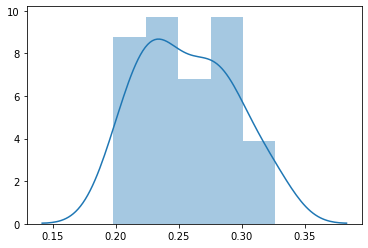

In [470]:
sns.distplot(y_predict)
plt.show()